In [1]:
#To start with the image classification we will follow a ML framework
# 1. Data ingestion
# 2. Data preparation
# 3. Model building
# 4. Model Training
# 5. Model evaluation
# 6. Model Inference

#require libraries in pytorch for the data and model
import torch.nn as nn
import torch
import torch.optim as optim

# for data
from torchvision import transforms,datasets
from torch.utils.data import DataLoader

In [2]:
import sys

data_path = "/content/drive/MyDrive/Pytorch Certification/Part-1 Fundamentals/Image Classification MNIST"

if data_path not in sys.path:
    sys.path.append(data_path)

In [3]:
import os
os.listdir(data_path)

['helper_utils.py', '__pycache__', 'MNIST', 'Image_Classification_MNIST.ipynb']

In [4]:
#before moving forwars with ingestion lets first see the dataset
dataset_train = datasets.MNIST(root=data_path,download=True,transform=None,train=True)
dataset_test = datasets.MNIST(root=data_path,train=False,transform=None,download=True)

In [5]:
#now lets load the first image
image,label= dataset_train[0]
print(f"Image type:{type(image)}")
print(f"Image shape:{image.size}")
print(f"label type:{type(label)}")
print(f"label value:{label}")
print(f"number of train samples:{len(dataset_train)}")
print(f"number of test samples:{len(dataset_test)}")


Image type:<class 'PIL.Image.Image'>
Image shape:(28, 28)
label type:<class 'int'>
label value:5
number of train samples:60000
number of test samples:10000


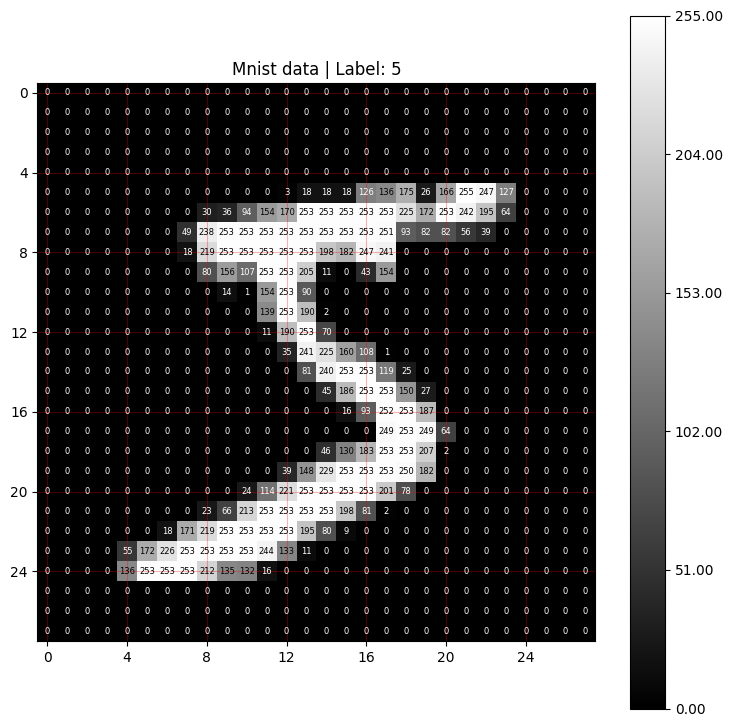

In [6]:
import helper_utils

helper_utils.display_image(image,label,title="Mnist data")

In [7]:
#1. Data ingestion
#to load the datafrom the dataset we need to define how pytorch loads the data so we need the transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

#load the dataset with transform
train_dataset = datasets.MNIST(root=data_path,train=True,download=True,transform=transform)
test_dataset = datasets.MNIST(root=data_path,train=False,download=True,transform=transform)

#inspect the dataset
#use the dataloader for the batches
train_loader = DataLoader(train_dataset,batch_size=64,shuffle= True)
test_loader = DataLoader(train_dataset,batch_size=1000,shuffle= False)

In [15]:
#now lets load the first image
image,label= train_dataset[0]
print(f"Image type:{type(image)}")
print(f"Image shape:{image.shape}")
print(f"label type:{type(label)}")
print(f"label value:{label}")
print(f"number of train samples:{len(dataset_train)}")
print(f"number of test samples:{len(dataset_test)}")
print(f"Number training batches:{len(train_loader)}")
print(f"Number testing batches:{len(test_loader)}")

Image type:<class 'torch.Tensor'>
Image shape:torch.Size([1, 28, 28])
label type:<class 'int'>
label value:5
number of train samples:60000
number of test samples:10000
Number training batches:938
Number testing batches:60


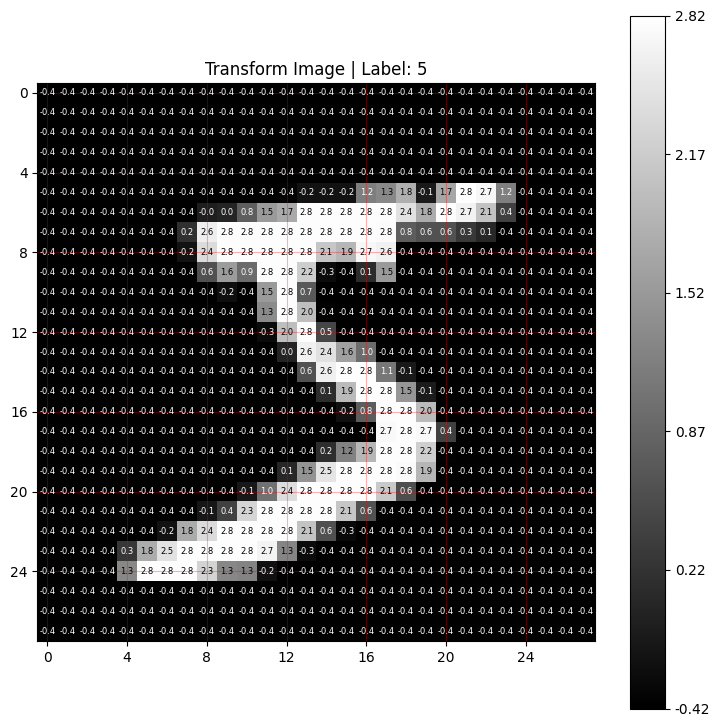

In [9]:
helper_utils.display_image(image,label,title="Transform Image")

In [10]:
#2. Model building
class MNISTClassfier(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.layer = nn.Sequential(
        nn.Linear(784,128),
        nn.ReLU(),
        nn.Linear(128,10)
    )
  def forward(self,x):
    x = self.flatten(x)
    x = self.layer(x)
    return x


In [16]:
from torch._prims_common import Dim
#3. Model training
#firstly we want to load the model into the GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MNISTClassfier()
# loss and optimizers
loss_function = nn.CrossEntropyLoss()
optimizers = optim.Adam(model.parameters(),lr=0.001)

def train_epoch(model,loss_function,device,train_loader,optimizers):
  #load the model to cuda
  model = model.to(device)
  #set the model in training mode
  model.train()

  # Initialize trackers for the entire epoch's loss
  epoch_loss = 0.0

  # Initialize trackers for periodic progress reporting
  running_loss = 0.0
  num_correct_predictions = 0
  total_predictions = 0
  total_batches = len(train_loader)

  #now to train on the all the batches
  for batch_idx, (inputs,targets) in enumerate(train_loader):
    #load the inputs and targets to devices
    inputs,targets = inputs.to(device) , targets.to(device)
    #training of each batch
    optimizers.zero_grad()

    #make prediction
    predict = model(inputs)

    #loss
    loss = loss_function(predict,targets)

    #backward
    loss.backward()
    #update weights
    optimizers.step()

    # Accumulate the loss for tracking and reporting
    loss_value = loss.item()
    epoch_loss += loss_value
    running_loss += loss_value

    # Calculate accuracy metrics for the current batch
    _, predicted_indices = predict.max(1)
    batch_size = targets.size(0)
    total_predictions += batch_size
    num_correct_in_batch = predicted_indices.eq(targets).sum().item()
    num_correct_predictions += num_correct_in_batch

    # Check if it's time to print a progress update
    if (batch_idx + 1) % 134 == 0 or (batch_idx + 1) == total_batches:
      # Calculate average loss and accuracy for the current interval
      avg_running_loss = running_loss / 134
      accuracy = 100. * num_correct_predictions / total_predictions

      # Print the progress update
      print(f'\tStep {batch_idx + 1}/{total_batches} - Loss: {avg_running_loss:.3f} | Acc: {accuracy:.2f}%')

      # Reset the trackers for the next reporting interval
      running_loss = 0.0
      num_correct_predictions = 0
      total_predictions = 0

  # Calculate the average loss for the entire epoch
  avg_epoch_loss = epoch_loss / total_batches
  # Return the trained model and the average epoch loss
  return model, avg_epoch_loss

In [17]:
#Model Evaluating
def evaluate(model,test_loader,device):
  #set the model into evaluation stage
  model.eval()

  total_predictions = 0
  num_correct_predictions = 0

  with torch.no_grad():
    for inputs,targets in test_loader:
      #load that into the device
      inputs,targets = inputs.to(device), targets.to(device)

      #run the inference
      outputs = model(inputs)

      #get the highest value confidence to get the prediction
      _,prediction = outputs.max(1)

      batch_size = targets.size(0)
      total_predictions += batch_size
      correct_prediction = prediction.eq(targets)
      num_correct_predictions += correct_prediction.sum().item()

  accuracy = (num_correct_predictions/total_predictions)*100
  print((f'\tAccuracy - {accuracy:.2f}%'))
  return accuracy


In [18]:
#6 Training
num_epochs = 5

#intlaize the lists to store the metrics from each epochs
train_loss = []
test_acc = []

for epoch in range(num_epochs):
  print(f"\n[Training] Epoch {epoch+1}:")
  trained_model, loss = train_epoch(model,loss_function,device,train_loader,optimizers)
  train_loss.append(loss)
  print(f"\n[Testing] Epoch {epoch+1}:")
  accuracy = evaluate(trained_model,test_loader,device)
  test_acc.append(accuracy)




[Training] Epoch 1:
	Step 134/938 - Loss: 0.550 | Acc: 84.26%
	Step 268/938 - Loss: 0.287 | Acc: 91.50%
	Step 402/938 - Loss: 0.239 | Acc: 93.06%
	Step 536/938 - Loss: 0.209 | Acc: 93.82%
	Step 670/938 - Loss: 0.184 | Acc: 94.73%
	Step 804/938 - Loss: 0.157 | Acc: 95.17%
	Step 938/938 - Loss: 0.155 | Acc: 95.42%

[Testing] Epoch 1:
	Accuracy - 96.58%

[Training] Epoch 2:
	Step 134/938 - Loss: 0.127 | Acc: 96.28%
	Step 268/938 - Loss: 0.110 | Acc: 96.64%
	Step 402/938 - Loss: 0.119 | Acc: 96.30%
	Step 536/938 - Loss: 0.110 | Acc: 96.77%
	Step 670/938 - Loss: 0.114 | Acc: 96.63%
	Step 804/938 - Loss: 0.100 | Acc: 97.01%
	Step 938/938 - Loss: 0.099 | Acc: 96.92%

[Testing] Epoch 2:
	Accuracy - 97.71%

[Training] Epoch 3:
	Step 134/938 - Loss: 0.076 | Acc: 97.61%
	Step 268/938 - Loss: 0.087 | Acc: 97.42%
	Step 402/938 - Loss: 0.074 | Acc: 97.74%
	Step 536/938 - Loss: 0.084 | Acc: 97.45%
	Step 670/938 - Loss: 0.072 | Acc: 97.71%
	Step 804/938 - Loss: 0.078 | Acc: 97.66%
	Step 938/938 - Los

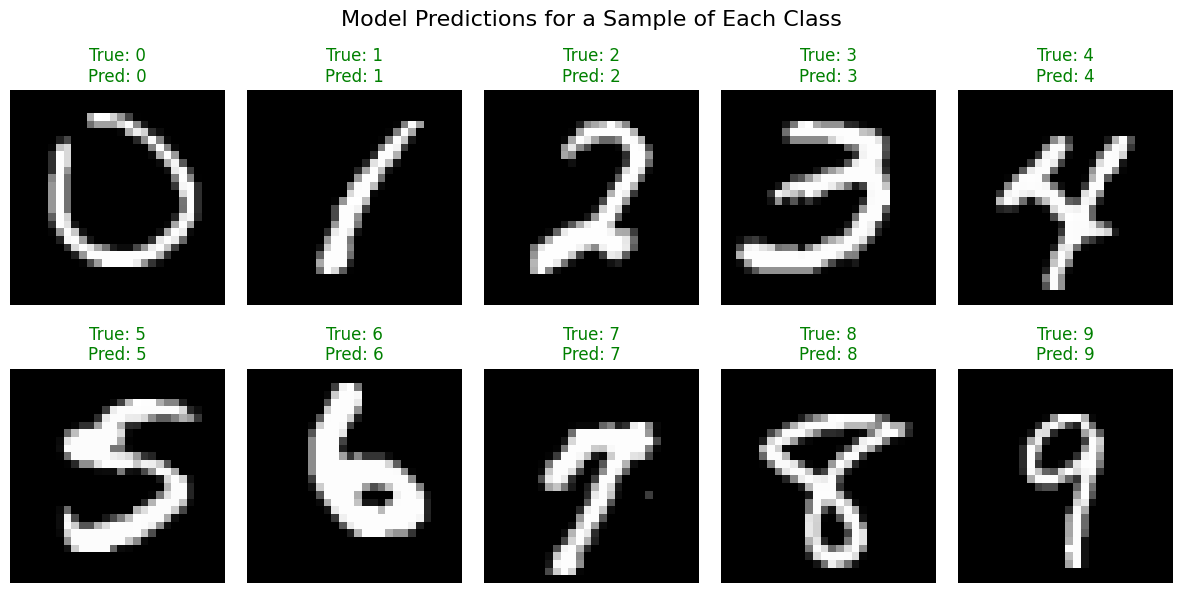

In [19]:
# Visualize model predictions on a random sample of test images
helper_utils.display_predictions(trained_model, test_loader, device)

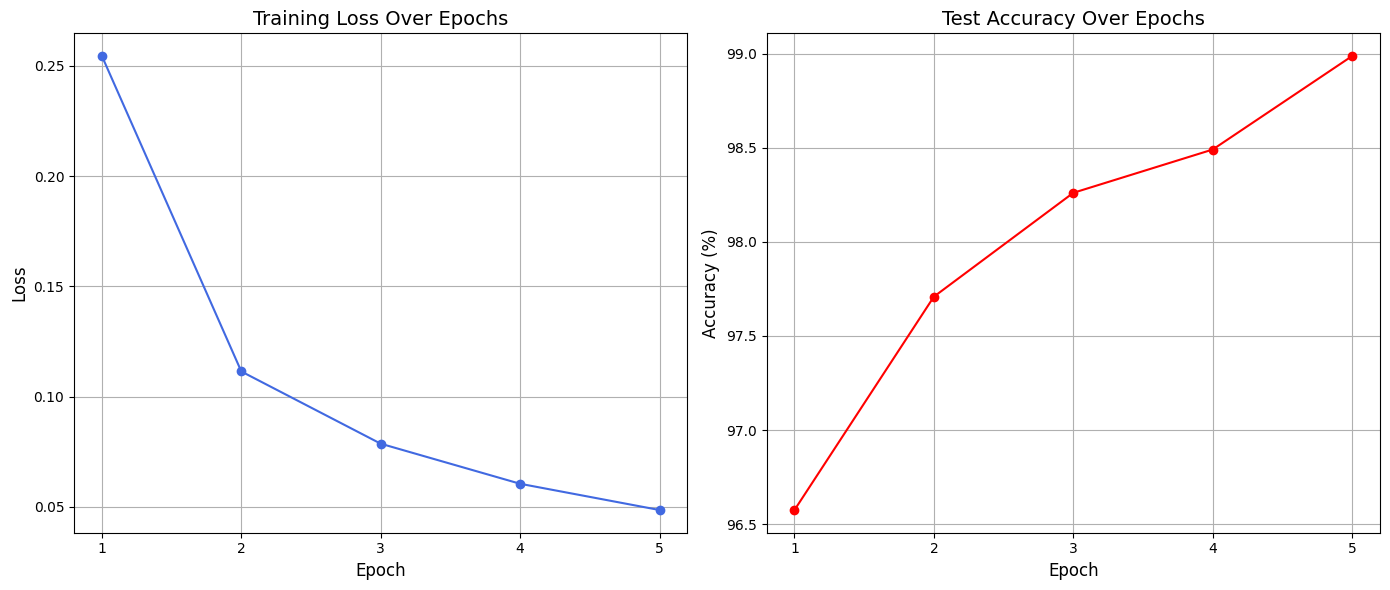

In [20]:
# Plot the training loss and test accuracy curves over all epochs
helper_utils.plot_metrics(train_loss, test_acc)